In [1]:
import numpy as np
import scipy as sc
import scipy.sparse
import oracles
import optimization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
import time
import oracles
from scipy.special import expit
import numpy as np

class get_batch:
    def __init__(self, batch_size, file_name, vectorizer):
        self.batch_size = batch_size
        self.file_name = file_name
        self.vectorizer = vectorizer
    
    def __iter__(self):
        self.iter = pd.read_csv("mixed_data.csv", iterator=True, chunksize=self.batch_size, index_col=0)
        return self
    
    def __next__(self):
        try:
            comments = self.iter.get_chunk()
        except StopIteration:
            self.iter = pd.read_csv("mixed_data.csv", iterator=True, 
                                    chunksize=self.batch_size, index_col=0)
            comments = self.iter.get_chunk()
        comments.fillna("", inplace=True)
        return self.vectorizer.transform(comments["comment_text"])

    
class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
                
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход 
        
        max_iter - максимальное число итераций     
        
        **kwargs - аргументы, необходимые для инициализации   
        """
        if loss_function == 'binary_logistic':
            self.oracle_ = oracles.BinaryLogistic(**kwargs)
            
        self.step_alpha_ = step_alpha
        self.step_beta_ = step_beta
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter
        self.kwargs_ = kwargs
        
        
    def fit(self, X, y, w_0=None, trace=False, X_val=None, y_val=None):
        """
        Обучение метода по выборке X с ответами y
        
        X, X_val - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y, y_val - одномерный numpy array
        
        w_0 - начальное приближение в методе
        
        trace - переменная типа bool
      
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        history['accuracy']: list of floats, содержит значения accuracy на валидационной выборке на каждой итерации
        (0 для самой первой точки)
        """

        self.weights_ = w_0
        iter_num = 0
        
        history = {}
        last_func = 0
        cur_func = self.oracle_.func(X, y, self.weights_)
        
        if trace == True:
            history["time"] = [0]
            history["func"] = [cur_func]
            if X_val != None:
                y_pred = self.predict(X_val) 
                history["accuracy"] = [(y_pred==y_val).sum()/y_val.size]
                
        start_time = time.time()
        
        while iter_num < self.max_iter_ and \
                abs(last_func-cur_func) > self.tolerance_:
            last_func = cur_func
            iter_num += 1
            
            rate = self.step_alpha_ / iter_num ** self.step_beta_
            
            self.weights_ = self.weights_ - rate*self.oracle_.grad(X, y, self.weights_)
            
            cur_func = self.oracle_.func(X, y, self.weights_)
            
            if trace == True:
                history["time"].append(time.time() - start_time)
                history["func"].append(cur_func)
                start_time = time.time()
                if X_val != None:
                    y_pred = self.predict(X_val) 
                    history["accuracy"].append((y_pred==y_val).sum()/y_val.size)
                    
        if trace == True:
            return history
        
    def predict(self, X):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        answer = np.sign(X.dot(self.weights_))
        answer[answer == 0] = 1
        return answer
    
    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k 
        """
        answer = np.zeros((X.shape[0], 2))
        answer[:, 1] = expit(X.dot(self.weights_))
        answer[:, 0] = 1 - answer[:, 1]
        return answer
    
    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        return self.oracle_.func(X, y, self.weights_)
        
    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        return self.oracle_.grad(X, y, self.weights_)
    
    def get_weights(self):
        """
        Получение значения весов функционала
        """    
        return self.weights_


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        
        batch_size - размер подвыборки, по которой считается градиент
        
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход 
        
        
        max_iter - максимальное число итераций (эпох)
        
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        
        **kwargs - аргументы, необходимые для инициализации
        """
        
        if loss_function == 'binary_logistic':
            self.oracle_ = oracles.BinaryLogistic(**kwargs)
        
        self.random_seed_ = random_seed
        self.step_alpha_ = step_alpha
        self.step_beta_ = step_beta
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter
        self.kwargs_ = kwargs
        self.batch_size_ = batch_size
        
    def fit(self, X, y, w_0=None, trace=False, log_freq=1, X_val=None, y_val=None):
        """
        Обучение метода по выборке X с ответами y
        
        X, X_val - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y, y_val - одномерный numpy array
                
        w_0 - начальное приближение в методе
        
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления. 
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        history['accuracy']: list of floats, содержит значения accuracy на валидационной выборке на каждой итерации
        (0 для самой первой точки)
        """
        
        self.weights_ = w_0
        iter_num = 0
        
        history = {}
        last_func = 0
        cur_func = self.oracle_.func(X, y, self.weights_)
        obj_num = 0
        last_log = 0
        last_weights = w_0
        
        if trace == True:
            history['epoch_num'] = [0]
            history["time"] = [0]
            history["func"] = [cur_func]
            history['weights_diff'] = [0]
            if X_val != None:
                y_pred = self.predict(X_val) 
                history["accuracy"] = [(y_pred==y_val).sum()/y_val.size]
                
        start_time = time.time()
        
        while last_log < self.max_iter_ and \
                abs(last_func-cur_func) > self.tolerance_:
            
            indices_permutation = np.random.permutation(y.size)
            
            for j in range(0, y.size, self.batch_size_):
                indices = indices_permutation[j:j+self.batch_size_]
                obj_num += indices.size
                iter_num += 1

                rate = self.step_alpha_ / iter_num**self.step_beta_

                self.weights_ = self.weights_ - rate*self.oracle_.grad(X[indices], y[indices], self.weights_)
                
                if obj_num / y.size - last_log >= log_freq:
                    last_func = cur_func
                    cur_func = self.oracle_.func(X, y, self.weights_)
                    last_log = obj_num / y.size
                    
                    if trace == True:
                        history['epoch_num'].append(last_log)
                        history["time"].append(time.time() - start_time)
                        history["func"].append(cur_func)
                        dif_w = last_weights - self.weights_
                        history['weights_diff'].append(dif_w.dot(dif_w))
                        if X_val != None:
                            y_pred = self.predict(X_val) 
                            history["accuracy"].append((y_pred==y_val).sum()/y_val.size)
                            
                    start_time = time.time()
        
        if trace == True:
            return history

    def fit_special(self, X_iter, y, w_0=None, log_freq=1):
        self.weights_ = w_0
        iter_num = 0

        obj_num = 0
        last_log = 0
        last_weights = w_0
        y_begin = 0

        start_time = time.time()
        
        while last_log < self.max_iter_:

            X_train = next(X_iter)
            obj_num += X_train.shape[0]
            iter_num += 1
            y_train = y[y_begin:y_begin + X_train.shape[0]]
            y_begin += X_train.shape[0]
            if y_begin == y.size:
                y_begin = 0

            rate = self.step_alpha_ / iter_num**self.step_beta_

            self.weights_ = self.weights_ - rate*self.oracle_.grad(X_train, y_train, self.weights_)

            if obj_num / y.size - last_log >= log_freq:
                last_log = obj_num / y.size
                print(last_log)

In [47]:
toxic_train = pd.read_csv("toxic_train.csv", index_col=0)
data_train = toxic_train[["comment_text"]]
y_train = np.ones(toxic_train.shape[0]) * (-1)
y_train[toxic_train["is_toxic"].values] = 1

In [149]:
toxic_test = pd.read_csv("toxic_test.csv", index_col=0)
data_test = toxic_test[["comment_text"]]
y_test = np.ones(toxic_test.shape[0]) * (-1)
y_test[toxic_test["is_toxic"].values] = 1

In [49]:
data_train.head(5)

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


In [50]:
y_train

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [51]:
import re

def preprocessing(s):
    s_new = s.lower()
    if not s_new.isalnum():
        s_new = re.sub(r'\W',' ', s_new).strip()
    return s_new

In [52]:
pd.options.mode.chained_assignment = None
data_train["comment_text"] = data_train["comment_text"].apply(preprocessing)
data_test["comment_text"] = data_test["comment_text"].apply(preprocessing)

In [53]:
data_test.head(5)

,comment_text
0,thank you for understanding i think very high...
1,dear god this site is horrible
2,somebody will invariably try to add religion ...
3,it says it right there that it is a type the ...
4,before adding a new product to the list make ...


In [54]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5)
vectorizer.fit(data_train["comment_text"])
X_train = vectorizer.transform(data_train["comment_text"])
X_test = vectorizer.transform(data_test["comment_text"])

In [10]:
betas = [0, 0.5, 1]
alphas = [1, 1e-1, 1e-2]

history = [[0] * 3 for i in range(3)]
i = 0
for alpha in alphas:
    j = 0
    for beta in betas:
        clf = optimization.GDClassifier("binary_logistic", step_alpha=alpha, 
                                        step_beta=beta, max_iter=1000, l2_coef=1e-1)
        history[i][j] = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True)
        j += 1
    i += 1

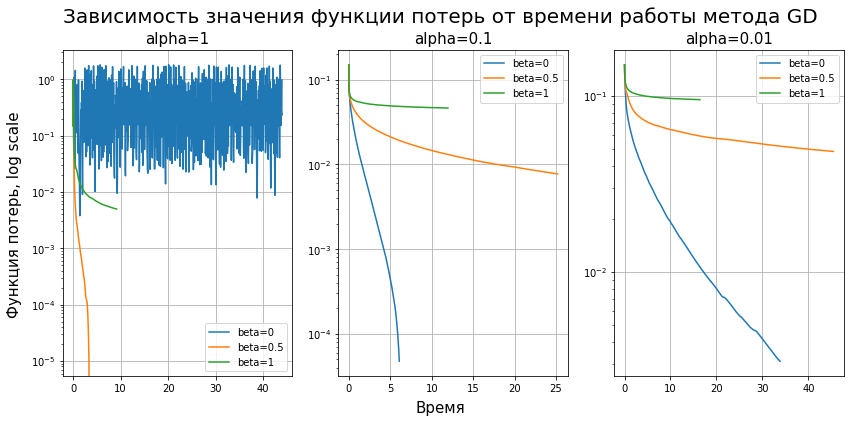

In [11]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(14, 6))

min_func = min([min(history[i][j]["func"]) for i in range(3) for j in range(3)])

for i in range(3):
    for j in range(3):
        time_list = np.cumsum(history[i][j]["time"])
        func_list = np.array(history[i][j]["func"])
        axes[i].semilogy(time_list, func_list - min_func, label="beta={}".format(betas[j]))
    axes[i].set_title("alpha={}".format(alphas[i]), fontsize=15)
    axes[i].tick_params(which='both')
    axes[i].legend()
    axes[i].grid(True)
    
fig.suptitle("Зависимость значения функции потерь от времени работы метода GD", fontsize=20)

fig.text(0.5, 0.04, 'Время', ha='center', fontsize=15)
fig.text(0.07, 0.5, 'Функция потерь, log scale', va='center', rotation='vertical', fontsize=15)

fig.savefig("loss_time_log_GD.pdf")

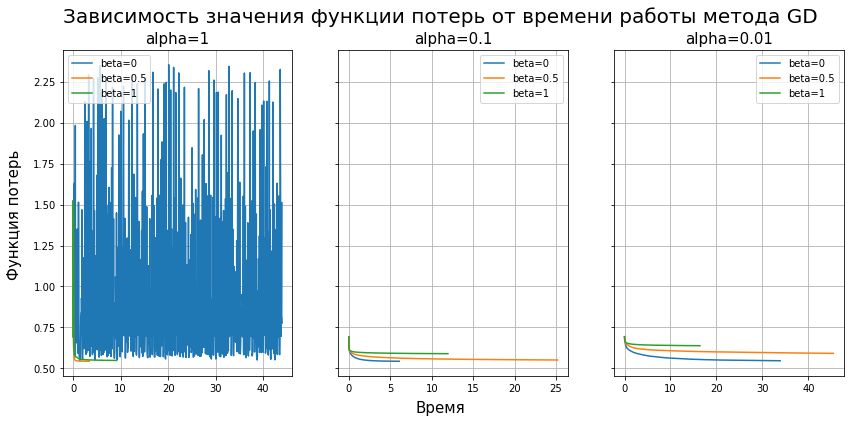

In [12]:
fig, axes = plt.subplots(1, 3, sharey="row", figsize=(14, 6))

min_func = min([min(history[i][j]["func"]) for i in range(3) for j in range(3)])

for i in range(3):
    for j in range(3):
        time_list = np.cumsum(history[i][j]["time"])
        func_list = np.array(history[i][j]["func"])
        axes[i].plot(time_list, func_list, label="beta={}".format(betas[j]))
    axes[i].set_title("alpha={}".format(alphas[i]), fontsize=15)
    axes[i].tick_params(which='both')
    axes[i].legend()
    axes[i].grid(True)
    
fig.suptitle("Зависимость значения функции потерь от времени работы метода GD", fontsize=20)

fig.text(0.5, 0.04, 'Время', ha='center', fontsize=15)
fig.text(0.07, 0.5, 'Функция потерь', va='center', rotation='vertical', fontsize=15)

fig.savefig("loss_time_GD.pdf")

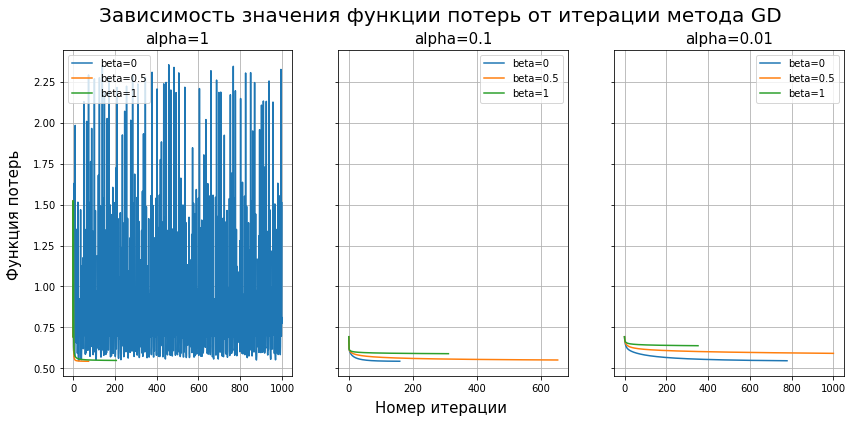

In [13]:
fig, axes = plt.subplots(1, 3, sharey="row", figsize=(14, 6))

min_func = min([min(history[i][j]["func"]) for i in range(3) for j in range(3)])

for i in range(3):
    for j in range(3):
        func_list = np.array(history[i][j]["func"])
        axes[i].plot(np.arange(func_list.size), func_list, label="beta={}".format(betas[j]))
    axes[i].set_title("alpha={}".format(alphas[i]), fontsize=15)
    axes[i].tick_params(which='both')
    axes[i].legend()
    axes[i].grid(True)
    
fig.suptitle("Зависимость значения функции потерь от итерации метода GD", fontsize=20)

fig.text(0.5, 0.04, 'Номер итерации', ha='center', fontsize=15)
fig.text(0.07, 0.5, 'Функция потерь', va='center', rotation='vertical', fontsize=15)

fig.savefig("loss_iteration_GD.pdf")

In [22]:
start_weights = np.vstack((np.zeros(X_train.shape[1]), np.ones(X_train.shape[1])*0.1, np.ones(X_train.shape[1])*0.2))

history = [0] * 3

i = 0
for w_0 in start_weights:
    clf = optimization.GDClassifier("binary_logistic", step_alpha=0.1, 
                                    step_beta=0, max_iter=1000, l2_coef=1e-1)
    history[i] = clf.fit(X_train, y_train, w_0=w_0, trace=True)
    i += 1
    


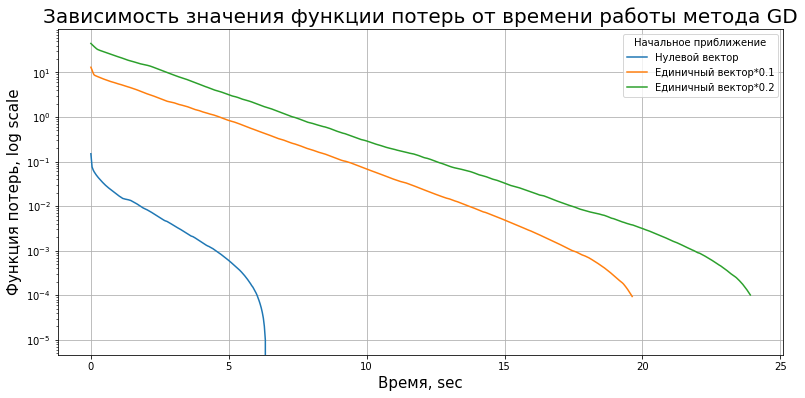

In [23]:
f = plt.figure(figsize=(13, 6))
min_func = min([min(history[i]["func"]) for i in range(3)])
labels = ["Нулевой вектор", "Единичный вектор*0.1", "Единичный вектор*0.2"]
for i in range(3):
    func_list = np.array(history[i]["func"])
    time_list = np.cumsum(history[i]["time"])
    plt.semilogy(time_list, func_list-min_func, label=labels[i])
    
plt.legend(title="Начальное приближение")
plt.grid()
plt.title("Зависимость значения функции потерь от времени работы метода GD", fontsize=20)
plt.xlabel("Время, sec", fontsize=15)
plt.ylabel("Функция потерь, log scale", fontsize=15)
f.savefig("loss_iteration_w0_GD.pdf")

In [24]:
betas = [0, 0.5, 1]
alphas = [1, 1e-1, 1e-2]

history = [[0] * 3 for i in range(3)]
i = 0
for alpha in alphas:
    j = 0
    for beta in betas:
        clf = optimization.SGDClassifier("binary_logistic", step_alpha=alpha, batch_size = 100,
                                        step_beta=beta, max_iter=1000, l2_coef=1e-1)
        history[i][j] = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, log_freq=0.5)
        j += 1
    i += 1

C:\Users\Acer\JUPYTER NOTEBOOK\VMK\PRAC\6 exs\optimization.py:249: RuntimeWarning: invalid value encountered in double_scalars
  abs(last_func-cur_func) > self.tolerance_:


In [40]:
np.array(history[0][0]["func"]) == np.inf

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False,  True, False, False,
       False,  True, False, False, False, False,  True, False,  True,
        True])

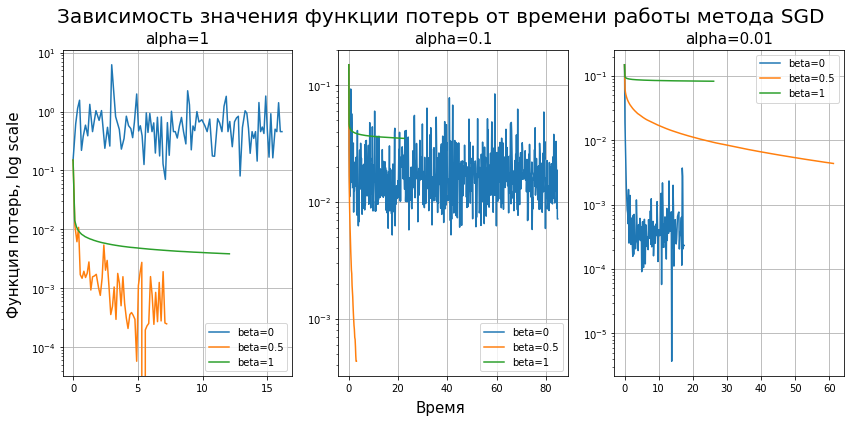

In [41]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(14, 6))

min_func = min([min(history[i][j]["func"]) for i in range(3) for j in range(3)])

for i in range(3):
    for j in range(3):
        time_list = np.cumsum(history[i][j]["time"])
        func_list = np.array(history[i][j]["func"])
        func_list[func_list == np.inf] = 1
        axes[i].semilogy(time_list, func_list - min_func, label="beta={}".format(betas[j]))
    axes[i].set_title("alpha={}".format(alphas[i]), fontsize=15)
    axes[i].tick_params(which='both')
    axes[i].legend()
    axes[i].grid(True)
    
fig.suptitle("Зависимость значения функции потерь от времени работы метода SGD", fontsize=20)

fig.text(0.5, 0.04, 'Время', ha='center', fontsize=15)
fig.text(0.07, 0.5, 'Функция потерь, log scale', va='center', rotation='vertical', fontsize=15)

fig.savefig("loss_time_log_SGD.pdf")

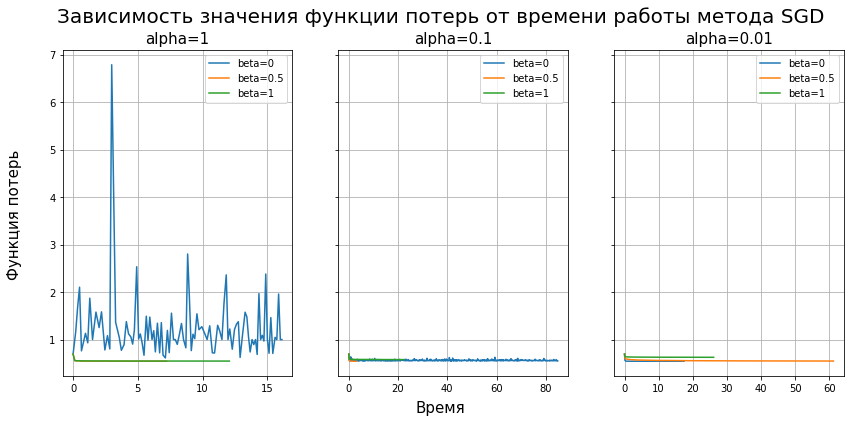

In [42]:
fig, axes = plt.subplots(1, 3, sharey="row", figsize=(14, 6))

min_func = min([min(history[i][j]["func"]) for i in range(3) for j in range(3)])

for i in range(3):
    for j in range(3):
        time_list = np.cumsum(history[i][j]["time"])
        func_list = np.array(history[i][j]["func"])
        func_list[func_list == np.inf] = 1
        axes[i].plot(time_list, func_list, label="beta={}".format(betas[j]))
    axes[i].set_title("alpha={}".format(alphas[i]), fontsize=15)
    axes[i].tick_params(which='both')
    axes[i].legend()
    axes[i].grid(True)
    
fig.suptitle("Зависимость значения функции потерь от времени работы метода SGD", fontsize=20)

fig.text(0.5, 0.04, 'Время', ha='center', fontsize=15)
fig.text(0.07, 0.5, 'Функция потерь', va='center', rotation='vertical', fontsize=15)

fig.savefig("loss_time_SGD.pdf")

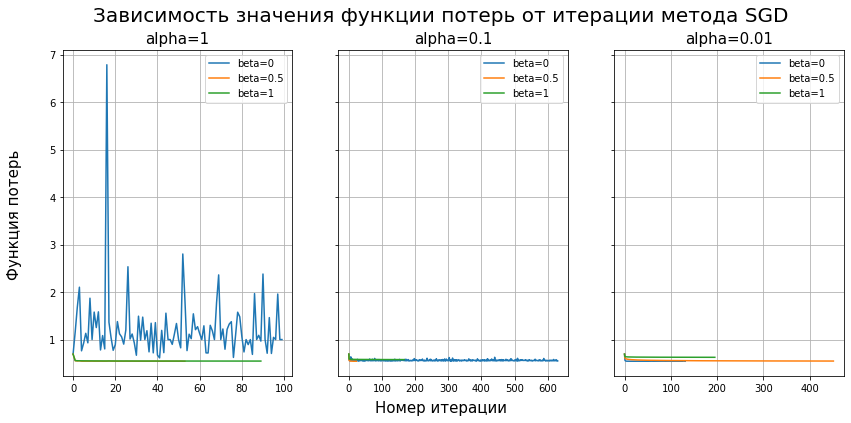

In [43]:
fig, axes = plt.subplots(1, 3, sharey="row", figsize=(14, 6))

min_func = min([min(history[i][j]["func"]) for i in range(3) for j in range(3)])

for i in range(3):
    for j in range(3):
        func_list = np.array(history[i][j]["func"])
        func_list[func_list == np.inf] = 1
        axes[i].plot(np.arange(func_list.size), func_list, label="beta={}".format(betas[j]))
    axes[i].set_title("alpha={}".format(alphas[i]), fontsize=15)
    axes[i].tick_params(which='both')
    axes[i].legend()
    axes[i].grid(True)
    
fig.suptitle("Зависимость значения функции потерь от итерации метода SGD", fontsize=20)

fig.text(0.5, 0.04, 'Номер итерации', ha='center', fontsize=15)
fig.text(0.07, 0.5, 'Функция потерь', va='center', rotation='vertical', fontsize=15)

fig.savefig("loss_iteration_SGD.pdf")

In [44]:
start_weights = np.vstack((np.zeros(X_train.shape[1]), np.ones(X_train.shape[1])*0.1, np.ones(X_train.shape[1])*0.2))

history = [0] * 3

i = 0
for w_0 in start_weights:
    clf = optimization.SGDClassifier("binary_logistic", step_alpha=1e-1, batch_size = 100,
                                        step_beta=0.5, max_iter=1000, l2_coef=1e-1)
    history[i] = clf.fit(X_train, y_train, w_0=w_0, trace=True, log_freq=0.5)
    i += 1
    


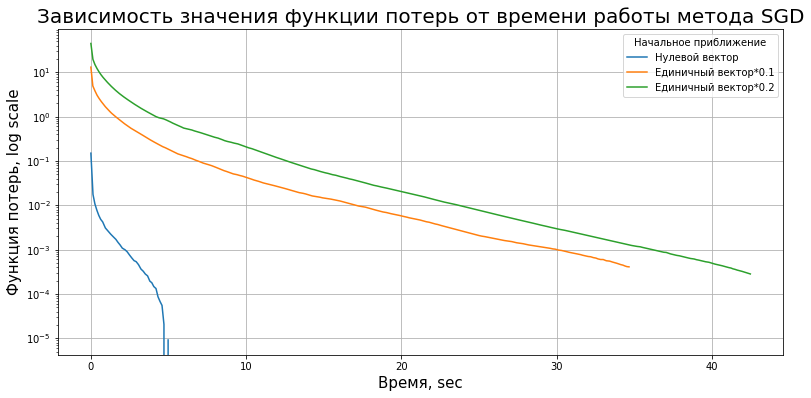

In [45]:
f = plt.figure(figsize=(13, 6))
min_func = min([min(history[i]["func"]) for i in range(3)])
labels = ["Нулевой вектор", "Единичный вектор*0.1", "Единичный вектор*0.2"]
for i in range(3):
    func_list = np.array(history[i]["func"])
    time_list = np.cumsum(history[i]["time"])
    plt.semilogy(time_list, func_list-min_func, label=labels[i])
    
plt.legend(title="Начальное приближение")
plt.grid()
plt.title("Зависимость значения функции потерь от времени работы метода SGD", fontsize=20)
plt.xlabel("Время, sec", fontsize=15)
plt.ylabel("Функция потерь, log scale", fontsize=15)
f.savefig("loss_iteration_w0_SGD.pdf")

In [46]:
from sklearn.model_selection import train_test_split
X_t, X_v, y_t, y_v = train_test_split(
     X_train, y_train, test_size=0.33, random_state=42)

In [53]:
clf = optimization.GDClassifier("binary_logistic", step_alpha=0.1, 
                                    step_beta=0, max_iter=1000, l2_coef=1e-1)
history_gd = clf.fit(X_t, y_t, w_0=np.zeros(X_train.shape[1]), trace=True, X_val=X_v, y_val=y_v)

In [50]:
clf = optimization.SGDClassifier("binary_logistic", step_alpha=1e-1, batch_size=100,
                                    step_beta=0.5, max_iter=1000, l2_coef=1e-1)
history_sgd = clf.fit(X_t, y_t, w_0=np.zeros(X_train.shape[1]), trace=True, 
                          log_freq=1, X_val=X_v, y_val=y_v)

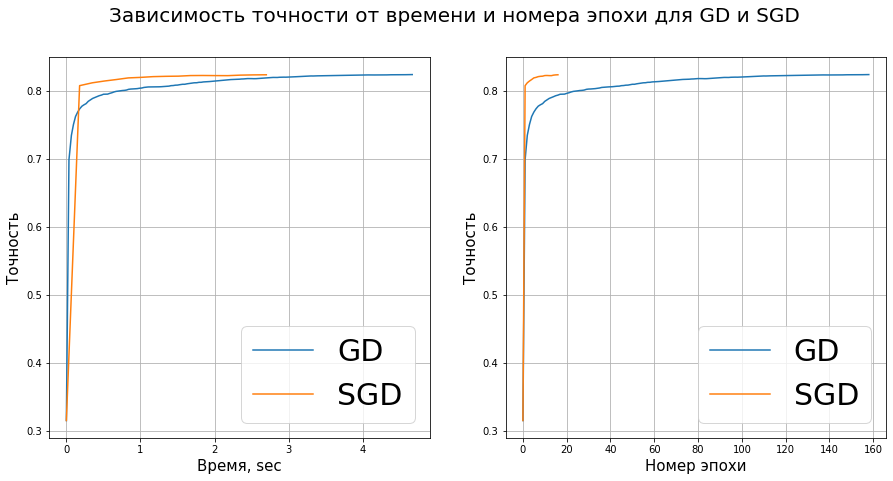

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

time_gd = np.cumsum(history_gd["time"])
time_sgd = np.cumsum(history_sgd["time"])

ax1.plot(time_gd, history_gd["accuracy"], label="GD")
ax1.plot(time_sgd, history_sgd["accuracy"], label="SGD")
ax1.legend(fontsize=30)
ax1.set_xlabel("Время, sec", fontsize=15)
ax1.set_ylabel("Точность", fontsize=15)
ax1.grid()

ax2.plot(np.arange(len(history_gd["accuracy"])), history_gd["accuracy"], label="GD")
ax2.plot(np.arange(len(history_sgd["accuracy"])), history_sgd["accuracy"], label="SGD")
ax2.legend(fontsize=30)
ax2.set_xlabel("Номер эпохи", fontsize=15)
ax2.set_ylabel("Точность", fontsize=15)
ax2.grid(which='both')

fig.suptitle("Зависимость точности от времени и номера эпохи для GD и SGD", fontsize=20)

fig.savefig("gd_sgd.pdf")

In [2]:
toxic_train = pd.read_csv("toxic_train.csv", index_col=0)
data_train = toxic_train[["comment_text"]]
y_train = np.ones(toxic_train.shape[0]) * (-1)
y_train[toxic_train["is_toxic"].values] = 1

In [3]:
toxic_test = pd.read_csv("toxic_test.csv", index_col=0)
data_test = toxic_test[["comment_text"]]
y_test = np.zeros(toxic_test.shape[0])
y_test[toxic_test["is_toxic"].values] = 1

In [4]:
data_train.head(5)

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


In [5]:
y_train

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [6]:
import re

def preprocessing(s):
    s_new = s.lower()
    if not s_new.isalnum():
        s_new = re.sub(r'\W',' ', s_new).strip()
    return s_new

In [7]:
pd.options.mode.chained_assignment = None
data_train["comment_text"] = data_train["comment_text"].apply(preprocessing)
data_test["comment_text"] = data_test["comment_text"].apply(preprocessing)

In [8]:
data_test.head(5)

,comment_text
0,thank you for understanding i think very high...
1,dear god this site is horrible
2,somebody will invariably try to add religion ...
3,it says it right there that it is a type the ...
4,before adding a new product to the list make ...


In [9]:
import nltk
from nltk.stem import WordNetLemmatizer

def lematize(s):
    words = nltk.word_tokenize(s)
    lemmatizer = WordNetLemmatizer()
    lemmatized_s = ' '.join([lemmatizer.lemmatize(w) for w in words])
    return lemmatized_s

In [10]:
data_train["comment_text"] = data_train["comment_text"].apply(lematize)
data_test["comment_text"] = data_test["comment_text"].apply(lematize)

In [11]:
data_train.head(5)

,comment_text
0,explanation why the edits made under my userna...
1,d aww he match this background colour i m seem...
2,hey man i m really not trying to edit war it s...
3,more i can t make any real suggestion on impro...
4,you sir are my hero any chance you remember wh...


In [12]:
from nltk.corpus import stopwords
import string

def del_stopwords(s):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(s)
    filtered_words = [w for w in words if w not in stop_words] 

    filtered_s = " ".join(filtered_words)
    return filtered_s

In [13]:
data_train["comment_text"] = data_train["comment_text"].apply(del_stopwords)
data_test["comment_text"] = data_test["comment_text"].apply(del_stopwords)

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5)
vectorizer.fit(data_train["comment_text"])
X_train_2 = vectorizer.transform(data_train["comment_text"])
X_test_2 = vectorizer.transform(data_test["comment_text"])

In [64]:
print(X_train.shape[1])
print(X_train_2.shape[1])

18210
16189


In [62]:
from sklearn.model_selection import train_test_split

X_t_1, X_v_1, y_t, y_v = train_test_split(
     X_train, y_train, test_size=0.33, random_state=42)
X_t_2, X_v_2, _, _ = train_test_split(
     X_train_2, y_train, test_size=0.33, random_state=42)

In [68]:
X_v_2.shape

(17181, 16189)

In [69]:
clf = optimization.SGDClassifier("binary_logistic", step_alpha=1e-1, batch_size=100,
                                    step_beta=0.5, max_iter=1000, l2_coef=1e-1)
history_1 = clf.fit(X_t_1, y_t, w_0=np.zeros(X_train.shape[1]), trace=True, 
                          log_freq=1, X_val=X_v_1, y_val=y_v)

clf = optimization.SGDClassifier("binary_logistic", step_alpha=1e-1, batch_size=100,
                                    step_beta=0.5, max_iter=1000, l2_coef=1e-1)
history_2 = clf.fit(X_t_2, y_t, w_0=np.zeros(X_t_2.shape[1]), trace=True, 
                          log_freq=1, X_val=X_v_2, y_val=y_v)

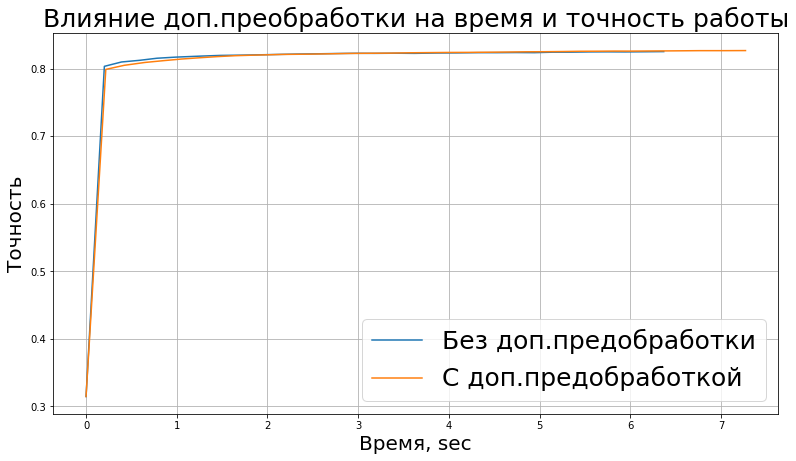

In [80]:
time_1 = np.cumsum(history_1["time"])
time_2 = np.cumsum(history_2["time"])

f = plt.figure(figsize=(13, 7))
plt.plot(time_1, history_1["accuracy"], label="Без доп.предобработки")
plt.plot(time_2, history_2["accuracy"], label="С доп.предобработкой")
plt.legend(fontsize=25)
plt.title("Влияние доп.преобработки на время и точность работы", fontsize=25)
plt.xlabel("Время, sec", fontsize=20)
plt.ylabel("Точность", fontsize=20)
plt.grid()

f.savefig("with_out_preprocess.pdf")

In [72]:
print(history_1["accuracy"][-1])
print(history_2["accuracy"][-1])

0.8256213258832431
0.8271346254583551


In [115]:
vectorizer = CountVectorizer(min_df=10, max_df=20)
vectorizer.fit(data_train["comment_text"])
X_train = vectorizer.transform(data_train["comment_text"])
X_test = vectorizer.transform(data_test["comment_text"])

In [118]:
y_train.shape

(52061,)

In [15]:
from sklearn.model_selection import train_test_split
data_t, data_v, y_t, y_v = train_test_split(data_train, y_train, test_size=0.33, random_state=42)

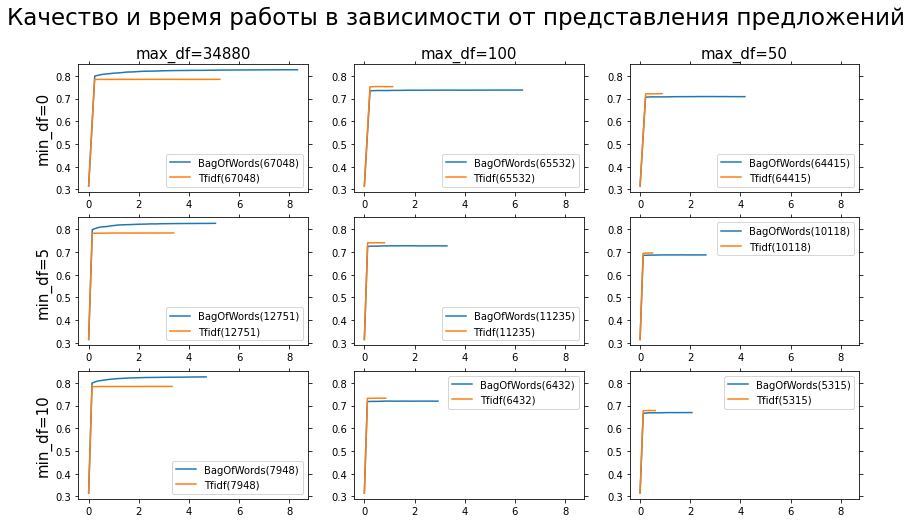

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

n = data_t.shape[0]
min_df_list = [0, 5, 10]
max_df_list = [n, 100, 50]

fig, axes = plt.subplots(3, 3, figsize=(14, 8), sharex='all', sharey='all')

clf = optimization.SGDClassifier("binary_logistic", step_alpha=1e-1, batch_size=100,
                                    step_beta=0.5, max_iter=1000, l2_coef=1e-1)

for i in range(3):
    
    for j in range(3):
        vectorizer = CountVectorizer(min_df=min_df_list[i], max_df=max_df_list[j])
        vectorizer.fit(data_t["comment_text"])
        X_train = vectorizer.transform(data_t["comment_text"])
        X_val = vectorizer.transform(data_v["comment_text"])
        history = clf.fit(X_train, y_t, w_0=np.zeros(X_train.shape[1]), trace=True, 
                              log_freq=1, X_val=X_val, y_val=y_v)
        time = np.cumsum(history["time"])
        axes[i][j].plot(time, history["accuracy"], label="BagOfWords({})".format(X_train.shape[1]))
        
        transformer = TfidfTransformer().fit(X_train)
        X_train = transformer.transform(X_train)
        X_val = transformer.transform(X_val)
        
        history = clf.fit(X_train, y_t, w_0=np.zeros(X_train.shape[1]), trace=True, 
                              log_freq=1, X_val=X_val, y_val=y_v)
        time = np.cumsum(history["time"])
        axes[i][j].plot(time, history["accuracy"], label="Tfidf({})".format(X_train.shape[1]))
        axes[i][j].tick_params(reset=True)
        axes[i][j].legend()
        
for i in range(3):
    axes[i][0].set_ylabel("min_df={}".format(min_df_list[i]), fontsize=15)
    axes[0][i].set_title("max_df={}".format(max_df_list[i]), fontsize=15)

fig.suptitle("Качество и время работы в зависимости от представления предложений", fontsize=23)

fig.savefig("bag_tfidf.pdf")

In [128]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(data_train["comment_text"])
X_train = vectorizer.transform(data_train["comment_text"])
X_test = vectorizer.transform(data_test["comment_text"])

In [140]:
clf = optimization.SGDClassifier("binary_logistic", step_alpha=1e-1, batch_size=100,
                                    step_beta=0.5, max_iter=1000, l2_coef=1e-1)

history = clf.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, log_freq=1)

In [141]:
pred_y = clf.predict(X_test)

In [152]:
(y_test==pred_y).sum()/len(y_test)

0.8256432578835364

In [155]:
data_wrong = data_test[y_test!=pred_y]
labels_wrong = y_test[y_test!=pred_y]

In [174]:
i=13
print(data_wrong["comment_text"].values[i])
print(labels_wrong[i])

for all peoples living East of a certain line, like the Vistula, because he distinguishes them from other large ethnic groups in the same area, the Fenni (probably Finno-Ugric) and the Sarmatians themselves. Taking that together with Jordanes'
-1.0


In [ ]:
i=3
print(data_wrong["comment_text"].values[i])
print(labels_wrong[i])

In [188]:
i=8
print(data_wrong["comment_text"].values[i])
print(labels_wrong[i])

== hrthrtdghrsdtghtrsdhtrhdgthjrtgh == 

 fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffhngviudfhgoiuerhgukfhkjgeruighervyfdohgobvijgfjgojfdhgjofhglkfhboerhgbdhoifdtyklerbhlkjhbdjgbojtgofgjrfjhlrkhilebotrjbh9jtrohibjrtlhujty;junmoytijoryjhigfjhgfjnifgjgfhkljtgilhjfdojgfdojgfkjngfdlkjgnklfgikfvihgifbfhbgkufbdsukfgglkdhvureuhgiurhgh4irtgyrehgui4t7iryggoifhgo54oerygtjeiygut8gopfe8gig89fjhg9r8tyr8hygb7hruegfigust8g0r0retugrijtrir6tihviurhgnviurwt,kcnguiergvknfgioerpjgklfupgrojgoirutkdhgl;rehgljkgyuorihfgiurwyhoug6y3oi4hg98w6u jtgnkjryt9jgoidug059jgiufd7teurjg98etujoijfgiosdug 0945ojtg0o8reuyjurfi ug945uj ygoip5uj5tg;eoiu495yp;w8y5urtg9ui8hui9g85w4mftmuv89tny0uvg8ytihguihfdkjvhu4krngkfdjs hgkjfghoeruygrhy goh tgoiugkiughgvhghghghhgghhghghghghghghghhhhhgtherkgheefjgsefdghh
-1.0


In [189]:
i=9
print(data_wrong["comment_text"].values[i])
print(labels_wrong[i])

== black mamba == 

 It.is ponious snake of the word and but it not kills many people but king cobra kills many people in India
-1.0


In [271]:

print(data_wrong["comment_text"].values[i])
print(labels_wrong[i])
i+=1

== stop being an ass == 

 It seems you are a German in love with your German magazine, thats just great. 
 One magazine has times, the rest of the world has times, dont try to suggest that your magazines times are more important. 
 The rest of the world doesnt really care about your magazine, they just care about times.
1.0


max_n=1: время=5.923313617706299 sec, точность=0.784878645014842
max_n=2: время=130.73727560043335 sec, точность=0.78482044118503
max_n=3: время=214.49023270606995 sec, точность=0.78627553693033


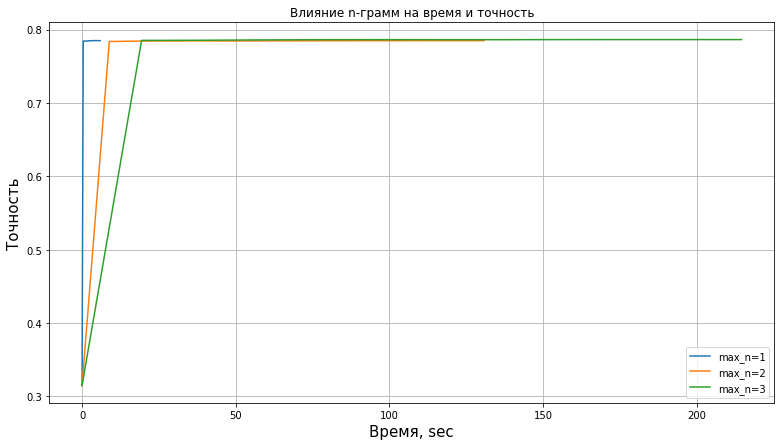

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
fig = plt.figure(figsize=(13,7))

data_t, data_v, y_t, y_v = train_test_split(data_train, y_train, test_size=0.33, random_state=42)
    
for max_n in range(1,4,1):
        vectorizer = TfidfVectorizer(ngram_range=(1, max_n))
        vectorizer.fit(data_t["comment_text"])
        X_train = vectorizer.transform(data_t["comment_text"])
        X_val = vectorizer.transform(data_v["comment_text"])
        history = clf.fit(X_train, y_t, w_0=np.zeros(X_train.shape[1]), trace=True, 
                              log_freq=1, X_val=X_val, y_val=y_v)
        time = np.cumsum(history["time"])
        plt.plot(time, history["accuracy"], label="max_n={}".format(max_n))
        print("max_n={0}: время={1} sec, точность={2}".format(max_n, time[-1], history["accuracy"][-1]))

plt.title("Влияние n-грамм на время и точность")
plt.xlabel("Время, sec", fontsize=15)
plt.ylabel("Точность", fontsize=15)
plt.grid()
plt.legend()

fig.savefig("n-gramms.pdf")

## 2 задание

In [271]:
toxic_train = pd.read_csv("toxic_train.csv", index_col=0)
mixed_toxic = toxic_train.sample(frac=1)
mixed_toxic.to_csv("mixed_data.csv")

In [282]:
toxic_train = pd.read_csv("mixed_data.csv", index_col=0)
data_train = toxic_train[["comment_text"]]
y_train = np.ones(toxic_train.shape[0]) * (-1)
y_train[toxic_train["is_toxic"].values] = 1

In [283]:
y_train

array([-1., -1., -1., ..., -1., -1.,  1.])

In [284]:
import re

def preprocessing(s):
    s_new = s.lower()
    if not s_new.isalnum():
        s_new = re.sub(r'\W',' ', s_new).strip()
    return s_new

In [285]:
pd.options.mode.chained_assignment = None
data_train["comment_text"] = data_train["comment_text"].apply(preprocessing)
data_test["comment_text"] = data_test["comment_text"].apply(preprocessing)

In [286]:
data_test.head(5)

,comment_text
0,thank you for understanding i think very high...
1,dear god this site is horrible
2,somebody will invariably try to add religion ...
3,it says it right there that it is a type the ...
4,before adding a new product to the list make ...


In [287]:
import nltk
from nltk.stem import WordNetLemmatizer

def lematize(s):
    words = nltk.word_tokenize(s)
    lemmatizer = WordNetLemmatizer()
    lemmatized_s = ' '.join([lemmatizer.lemmatize(w) for w in words])
    return lemmatized_s

In [288]:
data_train["comment_text"] = data_train["comment_text"].apply(lematize)

In [289]:
data_train.head(5)

,comment_text
20775,i hope this help
11625,i meant to say jolly good job talk
9131,whilst dr beck asked only that we take down th...
129807,removing cum stain from the faggot that jack o...
26344,well from the offering you have made on your w...


In [290]:
from nltk.corpus import stopwords
import string

def del_stopwords(s):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(s)
    filtered_words = [w for w in words if w not in stop_words] 

    filtered_s = " ".join(filtered_words)
    return filtered_s

In [291]:
data_train["comment_text"] = data_train["comment_text"].apply(del_stopwords)

In [292]:
vectorizer = CountVectorizer()
vectorizer.fit(data_train["comment_text"])

CountVectorizer()

In [293]:
clf = SGDClassifier("binary_logistic", step_alpha=1e-1, batch_size=100,
                                    step_beta=0.5, max_iter=10, l2_coef=1e-1)


In [266]:
mixed_data.shape

(52061, 1)

In [294]:
clf.fit_special(iter(try_batch), y_train, np.zeros(85335))

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
